<a href="https://colab.research.google.com/github/mayank-dahotre/Summer-Of-Quant-24/blob/main/Mayank%20Dahotre%20Backtesting_SOQ_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
!pip install pandas numpy matplotlib yfinance

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [99]:
import contextlib
import sys, os
import warnings
warnings.filterwarnings('ignore')


@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr


In [100]:
import yfinance as yf

def download_data(ticker, start_date, end_date):
    """
    Download historical stock data from Yahoo Finance.

    Parameters:
    ticker (str): Stock ticker symbol.
    start_date (str): Start date in 'YYYY-MM-DD' format.
    end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
    pd.DataFrame: Historical stock data.
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Date'] = data.index
    data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    return data


In [101]:
def moving_average_strategy(data, short_window, long_window):
    data['short_mavg'] = data['Close'].rolling(window=short_window).mean()
    data['long_mavg'] = data['Close'].rolling(window=long_window).mean()
    data['signal'] = 0
    data['signal'][short_window:] = np.where(data['short_mavg'][short_window:] > data['long_mavg'][short_window:], 1, 0)
    data['positions'] = data['signal'].diff()
    return data


def MACD(data, short_window, long_window, signal_window):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

def macd_strategy(data, short_window, long_window, signal_window):
    data['macd'], data['signal_line'] = MACD(data, short_window, long_window, signal_window)
    data['signal'] = 0
    data['signal'][short_window:] = np.where(data['macd'][short_window:] > data['signal_line'][short_window:], 1, 0)
    data['positions'] = data['signal'].diff()
    return data


In [102]:
def backtest(data, initial_capital):
    positions = pd.DataFrame(index=data.index).fillna(0.0)
    positions['Stock'] = 0.0  # Initialize the 'Stock' column with 0.0
    portfolio = pd.DataFrame(index=data.index).fillna(0.0)

    # Initial cash
    portfolio['cash'] = initial_capital
    portfolio['holdings'] = 0.0
    portfolio['total'] = initial_capital
    portfolio['returns'] = 0.0

    # Iterating through the data to simulate the trades
    for i in range(1, len(data)):
        if data['signal'].iloc[i] == 1 and portfolio['cash'].iloc[i-1] >= data['Close'].iloc[i] * 100:
            # Buy signal and enough cash available
            positions['Stock'].iloc[i] = positions['Stock'].iloc[i-1] + 100
            portfolio['cash'].iloc[i] = portfolio['cash'].iloc[i-1] - data['Close'].iloc[i] * 100
        elif data['signal'].iloc[i] == 0 and positions['Stock'].iloc[i-1] >= 100:
            # Sell signal and enough stock available
            positions['Stock'].iloc[i] = positions['Stock'].iloc[i-1] - 100
            portfolio['cash'].iloc[i] = portfolio['cash'].iloc[i-1] + data['Close'].iloc[i] * 100
        else:
            # No trade, carry forward previous positions and cash
            positions['Stock'].iloc[i] = positions['Stock'].iloc[i-1]
            portfolio['cash'].iloc[i] = portfolio['cash'].iloc[i-1]

        # Calculate holdings
        portfolio['holdings'].iloc[i] = positions['Stock'].iloc[i] * data['Close'].iloc[i]
        portfolio['total'].iloc[i] = portfolio['cash'].iloc[i] + portfolio['holdings'].iloc[i]
        portfolio['returns'].iloc[i] = portfolio['total'].pct_change().iloc[i]

    return portfolio


In [103]:
def generate_report(portfolio, initial_capital):
    total_return = portfolio['total'][-1] / initial_capital - 1
    annualized_return = (1 + total_return) ** (252 / len(portfolio)) - 1
    annualized_volatility = portfolio['returns'].std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility

    print(f'Total Return: {total_return:.2%}')
    print(f'Annualized Return: {annualized_return:.2%}')
    print(f'Annualized Volatility: {annualized_volatility:.2%}')
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

    plt.figure(figsize=(12, 8))
    plt.plot(portfolio['total'], label='Total Portfolio Value')
    plt.title('Equity Curve')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.show()


[*********************100%%**********************]  1 of 1 completed


Total Return: 28.08%
Annualized Return: 8.63%
Annualized Volatility: 16.24%
Sharpe Ratio: 0.53


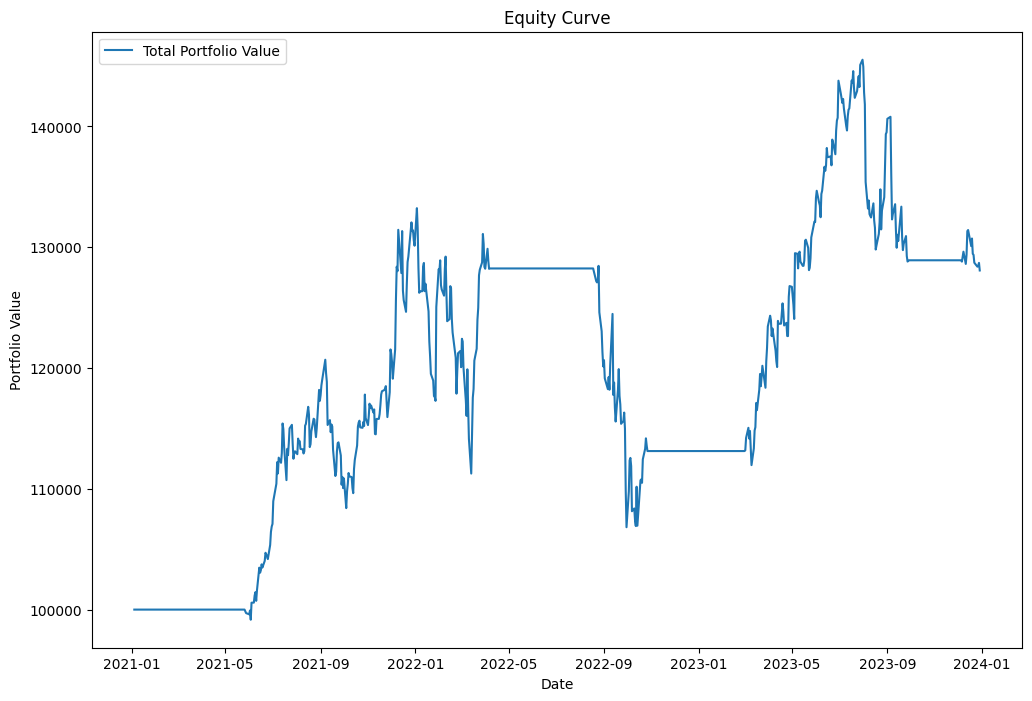

In [104]:
# Step 1: Download data
data = download_data('AAPL', '2021-01-01', '2024-01-01')

# Step 2: Apply a strategy and suppress output
with suppress_output():
    data = moving_average_strategy(data, short_window=40, long_window=100)

# Step 3: Backtest and suppress output
with suppress_output():
    initial_capital = 100000.0
    portfolio = backtest(data, initial_capital)

# Step 4: Generate report
generate_report(portfolio, initial_capital)


[*********************100%%**********************]  1 of 1 completed


Total Return: 39.25%
Annualized Return: 11.72%
Annualized Volatility: 15.58%
Sharpe Ratio: 0.75


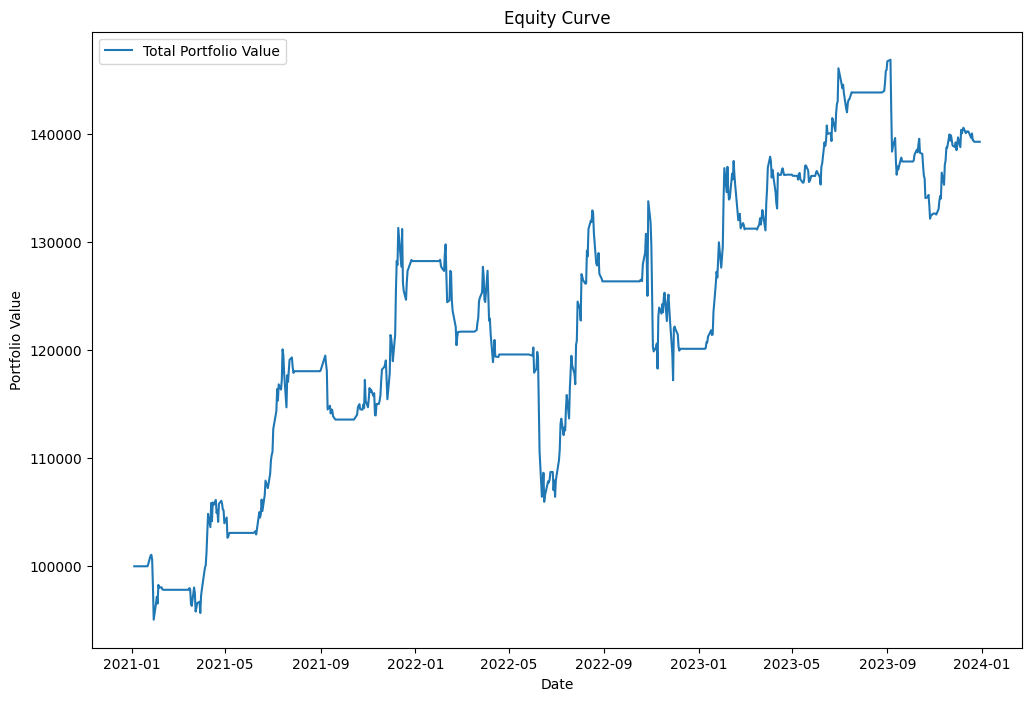

In [105]:
# Step 1: Download data
data = download_data('AAPL', '2021-01-01', '2024-01-01')

# Step 2: Apply a strategy and suppress output
with suppress_output():
    data = macd_strategy(data, short_window=12, long_window=26, signal_window=9)

# Step 3: Backtest and suppress output
with suppress_output():
    initial_capital = 100000.0
    portfolio = backtest(data, initial_capital)

# Step 4: Generate report
generate_report(portfolio, initial_capital)


In [106]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,macd,signal_line,signal,positions
Date,,,,,,,,,,,
2021-01-04,2021-01-04,133.520004,133.610001,126.760002,129.410004,126.830086,143301900,0.000000,0.000000,0,NaN
2021-01-05,2021-01-05,128.889999,131.740005,128.429993,131.009995,128.398193,97664900,0.127635,0.025527,0,0.0
2021-01-06,2021-01-06,127.720001,131.050003,126.379997,126.599998,124.076096,155088000,-0.125616,-0.004702,0,0.0
2021-01-07,2021-01-07,128.360001,131.630005,127.860001,130.919998,128.309982,109578200,0.022015,0.000642,0,0.0
2021-01-08,2021-01-08,132.429993,132.630005,130.229996,132.050003,129.417450,105158200,0.227573,0.046028,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,2023-12-22,195.179993,195.410004,192.970001,193.600006,193.091385,37122800,2.636317,3.236689,0,0.0
2023-12-26,2023-12-26,193.610001,193.889999,192.830002,193.050003,192.542816,28919300,2.306308,3.050613,0,0.0
2023-12-27,2023-12-27,192.490005,193.500000,191.089996,193.149994,192.642548,48087700,2.029448,2.846380,0,0.0


In [107]:
import numpy as np
import pandas as pd

def new_strategy(data):
    # Drop 'Date' column if it exists
    if 'Date' in data.columns:
        data = data.drop(['Date'], axis=1)

    # Sort by 'Date'
    data = data.sort_values('Date')

    # Calculate Moving Averages
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    data['MA_200'] = data['Close'].rolling(window=200).mean()

    # Calculate RSI
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / loss
    rs = rs.replace([np.inf, -np.inf], np.nan)  # Handle division by zero
    data['RSI'] = 100 - (100 / (1 + rs))

    # Generate buy and sell signals
    data['signal'] = 0
    data.loc[data['MA_50'] > data['MA_200'], 'signal'] = 1  # Buy signal when MA_50 crosses above MA_200
    data.loc[data['MA_50'] < data['MA_200'], 'signal'] = 0  # Sell signal when MA_50 crosses below MA_200

    # Further refine signals using RSI
    data.loc[(data['RSI'] < 30) & (data['MA_50'] > data['MA_200']), 'signal'] = 1  # Buy signal if RSI is low
    data.loc[(data['RSI'] > 70) & (data['MA_50'] < data['MA_200']), 'signal'] = 0  # Sell signal if RSI is high

    # Drop 'Date' column if it exists
    if 'Date' in data.columns:
        data = data.drop(['Date'], axis=1)

    # Ensure columns include 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', and 'signal'
    required_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'signal']
    for col in required_columns:
        if col not in data.columns:
            data[col] = np.nan  # Add missing columns with NaN values

    return data

In [108]:
data = download_data('AAPL', '2021-01-01', '2024-01-01')

[*********************100%%**********************]  1 of 1 completed


In [109]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2021-01-04,2021-01-04,133.520004,133.610001,126.760002,129.410004,126.830086,143301900
2021-01-05,2021-01-05,128.889999,131.740005,128.429993,131.009995,128.398193,97664900
2021-01-06,2021-01-06,127.720001,131.050003,126.379997,126.599998,124.076096,155088000
2021-01-07,2021-01-07,128.360001,131.630005,127.860001,130.919998,128.309982,109578200
2021-01-08,2021-01-08,132.429993,132.630005,130.229996,132.050003,129.417450,105158200
...,...,...,...,...,...,...,...
2023-12-22,2023-12-22,195.179993,195.410004,192.970001,193.600006,193.091385,37122800
2023-12-26,2023-12-26,193.610001,193.889999,192.830002,193.050003,192.542816,28919300
2023-12-27,2023-12-27,192.490005,193.500000,191.089996,193.149994,192.642548,48087700


[*********************100%%**********************]  1 of 1 completed


Total Return: 16.19%
Annualized Return: 5.15%
Annualized Volatility: 16.36%
Sharpe Ratio: 0.31


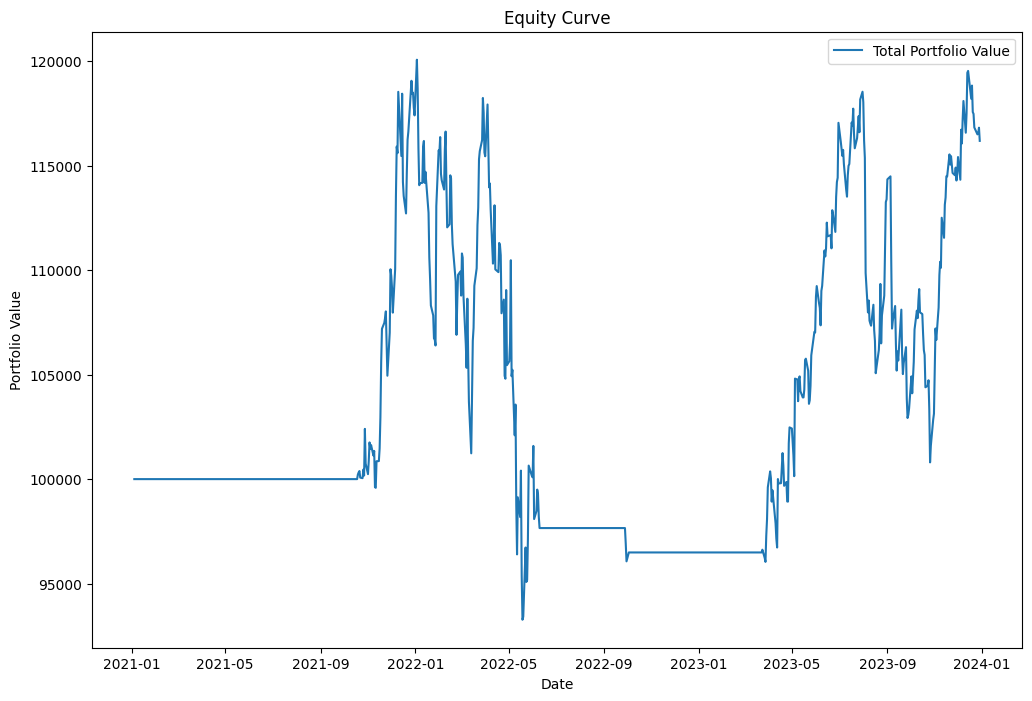

In [110]:
# Step 1: Download data
data = download_data('AAPL', '2021-01-01', '2024-01-01')

# Step 2: Apply a strategy and suppress output
with suppress_output():
    data = new_strategy(data)

# Step 3: Backtest and suppress output
with suppress_output():
    initial_capital = 100000.0
    portfolio = backtest(data, initial_capital)

# Step 4: Generate report
generate_report(portfolio, initial_capital)